In [1]:
import numpy as np
import pandas as pd
from scipy import stats
import pprint
import warnings
from pandas.errors import ParserWarning

pd.set_option('display.max_columns', 8)
pd.set_option('display.width', 1000)

import re
import os
from pathlib import Path
import warnings
import itertools
from typing import List, Dict, Tuple, Any, Union, Callable
from astropy.table import Table, MaskedColumn

from astroquery import mast
from astroquery.mast import Observations
from astropy.time import Time, TimeJD, TimeDelta
from astroquery.mast.missions import MastMissions

hst_mission = MastMissions(mission='hst')

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns
% matplotlib inline
plt.rcParams['figure.figsize'] = [7, 7]
plt.rcParams['figure.dpi'] = 300

from tqdm import tqdm
from pathos.multiprocessing import Pool
from functools import partial
from concurrent.futures import ProcessPoolExecutor, as_completed

# Autoreload extension
if 'autoreload' not in get_ipython().extension_manager.loaded:
    % load_ext autoreload

% autoreload 2

## Columns

### Planet Name
- plntname

### Observation
- centralwavelng: Central Wavelength [microns]
- bandwidth: Band Width [microns]
- facility: Facility
- instrument: Instrument
- plntranreflink: Reference

### Planet Properties
#### Transit Depth:
- plntransdep: Transit Depth [percentage]
- plntransdeperr1: Transit Depth Upper Unc. [percentage]
- plntransdeperr2: Transit Depth Lower Unc. [percentage]
- plntransdeplim: Transit Depth Limit Flag
#### Planet Radius:
- plnradj: Planet Radius [Jupiter radii]
- plnradjerr1: Planet Radius Upper Unc. [Jupiter radii]
- plnradjerr2: Planet Radius Lower Unc. [Jupiter radii]
- plnradjlim: Planet Radius Limit Flag
#### Ratio of Planet to Stellar Radius:
- plnratror: Ratio of Planet to Stellar Radius
- plnratrorerr1: Ratio of Planet to Stellar Radius Upper Unc.
- plnratrorerr2: Ratio of Planet to Stellar Radius Lower Unc.
- plnratrorlim: Ratio of Planet to Stellar Radius Limit Flag
#### Transit Mid-Point:
- plntranmid: Transit Mid-Point [BJD]
- plntranmiderr1: Transit Mid-Point Upper Unc. [BJD]
- plntranmiderr2: Transit Mid-Point Lower Unc. [BJD]
- plntranmidlim: Transit Mid-Point Limit Flag

In [2]:
# local setup
WDIR = Path().cwd().parent

CLEAN_TRANSMISSION_PATH = WDIR / "data/transitspec_with_spectral_elements.csv"
TAUREX_LIGHTCURVE_PATH = WDIR / "data/taurex_lightcurves_LW"
BE_LIGHTCURVE_PATH = WDIR / "data/SpectraBE"

In [3]:
# date in converters
jd_converter = lambda bjd_time: Time(bjd_time, format="jd")

In [4]:
df_transmission = pd.read_csv(CLEAN_TRANSMISSION_PATH,
                              header=0, index_col=0,
                              )

In [5]:
def dataframes_to_dicts(dfs: List[pd.DataFrame]) -> List[Dict[str, str]]:
    """
    Convert a list of DataFrames into a list of dictionaries, ensuring specific columns
    have the same value for all rows in each DataFrame.

    Parameters
    ----------
    dfs : List[pd.DataFrame]
        A list of DataFrames with specific columns.

    Returns
    -------
    List[Dict[str, str]]
        A list of dictionaries with specific column names as keys and their respective values.

    Raises
    ------
    ValueError
        If the specific columns don't have the same value for all rows in a DataFrame.
    """
    result = []

    # Define columns to check for equal values
    check_columns = ['plntname', 'facility', 'instrument', 'spectral_element', 'aperture', 'source']

    # Iterate over the DataFrames in the input list
    for df in dfs:

        # Check if the specific columns have the same value for all rows
        if not df[check_columns].nunique().eq(1).all():
            raise ValueError("Values in specific columns are not the same for all rows in a DataFrame.")

        # Create a dictionary with the specific columns as keys and their values
        columns_dict = df[check_columns].iloc[0].to_dict()

        # Append the dictionary to the result list
        result.append(columns_dict)

    return result


def split_missing_info_dataframes(df: pd.DataFrame) -> List[pd.DataFrame]:
    """
    Split the input DataFrame into a list of DataFrames based on unique combinations of
    specific columns.

    Parameters
    ----------
    df : pd.DataFrame
        A DataFrame with specific columns.

    Returns
    -------
    List[pd.DataFrame]
        A list of DataFrames with rows sharing the same values in specific columns.
    """
    # Define columns for grouping the DataFrames
    group_columns = ['plntname', 'facility', 'instrument']

    # Group the input DataFrame by the specified columns
    grouped_data = df.groupby(group_columns)

    # Create a list of DataFrames based on the grouped data
    result = [group_data for _, group_data in grouped_data]

    return result


def summarize_spectra(spectra_dicts: List[Dict[str, str]], label: str = "", verbose: bool = True) -> Dict[str, int]:
    """
    Summarize the input list of dictionaries by counting occurrences of specific elements.

    Parameters
    ----------
    spectra_dicts : List[Dict[str, str]]
        A list of dictionaries containing specific elements.
    verbose : bool, optional
        If True, print the summary, default is True.

    Returns
    -------
    Dict[str, int]
        A dictionary with the counts of specific elements in the input list.
    """
    # Initialize the output dictionary
    summary = {}

    # Find the number of spectra in the input
    summary['spectra'] = len(spectra_dicts)

    # Define columns for counting occurrences
    count_columns = ['plntname', 'facility', 'instrument', 'spectral_element', 'aperture']

    # Count occurrences for each element in count_columns
    for column in count_columns:
        summary[column] = {}
        for d in spectra_dicts:
            key = d[column]
            summary[column][key] = summary[column].get(key, 0) + 1

    # Print the summary if verbose is True
    if verbose:
        print(label + "Summary:")
        for key, value in summary.items():
            print(f"  {key}:")
            if isinstance(value, dict):
                inverted = {}
                for k, v in value.items():
                    if v not in inverted:
                        inverted[v] = [k]
                    else:
                        inverted[v].append(k)

                for count, items in inverted.items():
                    print(f"    {', '.join(items)}: {count}")
            else:
                print(f"    {value}")

    return summary


def alias_this(s: str):
    alias_dict = {
        "Wide Field Camera 3": "WFC3",
        "Space Telescope Imaging Spectrograph": "STIS",
        "Hubble Space Telescope satellite": "HST",
        "Hubble Space Telescope": "HST",
        # Add more aliases as necessary
    }
    if s in alias_dict:
        return alias_dict[s]
    else:
        return s

In [6]:
def split_dataframes(df: pd.DataFrame) -> List[pd.DataFrame]:
    """
    Split the input DataFrame into a list of DataFrames based on unique combinations of
    specific columns. Additionally, filter out rows with "FAILURE" in spectral_element or aperture
    and collect them in a separate missing_data DataFrame.

    Parameters
    ----------
    df : pd.DataFrame
        A DataFrame with specific columns.

    Returns
    -------
    List[pd.DataFrame]
        A list of DataFrames with rows sharing the same values in specific columns.
    """
    # Create a temporary DataFrame with rows containing "FAILURE" dropped
    temp_df = df[~(df['spectral_element'].str.contains("FAILURE") | df['aperture'].str.contains("FAILURE"))]

    # Collect rows with "FAILURE" in spectral_element or aperture in a separate missing_data DataFrame
    missing_data = df[df['spectral_element'].str.contains("FAILURE") | df['aperture'].str.contains("FAILURE")]

    missing_data = split_missing_info_dataframes(missing_data)
    missing_data = dataframes_to_dicts(missing_data)
    __ = summarize_spectra(missing_data, label="MISSING DATA ")

    # Define columns for grouping the DataFrames
    group_columns = ['plntname', 'plntranreflink', 'facility', 'instrument', 'spectral_element', 'aperture']

    # Group the temporary DataFrame by the specified columns
    grouped_data = temp_df.groupby(group_columns)

    # Create a list of DataFrames based on the grouped data
    result = [group_data for _, group_data in grouped_data]

    return result

In [7]:
split_transmission = split_dataframes(df_transmission)

MISSING DATA Summary:
  spectra:
    0
  plntname:
  facility:
  instrument:
  spectral_element:
  aperture:


In [8]:
transmission_dicts = dataframes_to_dicts(split_transmission)
summary = summarize_spectra(transmission_dicts)

Summary:
  spectra:
    65
  plntname:
    55 Cnc e, CoRoT-1 b, GJ 1132 b, GJ 436 b, HAT-P-11 b, HAT-P-41 b, HD 97658 b, TRAPPIST-1 g, TrES-2 b, TrES-4 b, WASP-101 b, WASP-117 b, WASP-43 b, WASP-74 b, WASP-76 b, WASP-79 b, XO-1 b: 1
    GJ 1214 b, HAT-P-26 b, K2-18 b, KELT-11 b, WASP-107 b, WASP-121 b, WASP-31 b: 2
    GJ 3470 b, HAT-P-12 b, HD 209458 b, WASP-17 b, WASP-19 b, WASP-39 b: 3
    HAT-P-1 b: 4
    HD 189733 b: 7
    WASP-12 b: 5
  facility:
    Hubble Space Telescope satellite: 64
    Hubble Space Telescope: 1
  instrument:
    Wide Field Camera 3: 44
    WFC3: 4
    Space Telescope Imaging Spectrograph: 17
  spectral_element:
    G141: 37
    F139M: 2
    F606W: 5
    MIRVIS, G102, E230M: 1
    G430L: 15
    G280: 3
  aperture:
    GRISM512: 4
    GRISM128, IRSUB512: 2
    UVIS2-C512C-SUB: 5
    GRISM256: 25
    52X0.05, 0.2X0.2, IRSUB256: 1
    52X2: 15
    IRSUB128: 6
    UVIS: 3


In [9]:
def filter_dataframes_by_kw(dfs: List[pd.DataFrame], summary_dicts: List[Dict[str, str]], **filters) -> List[
    List[Union[pd.DataFrame, Dict[str, str]]]]:
    """
    Filter the input list of DataFrames based on specific values of the fields in the
    corresponding summary dictionaries, as specified by the keyword arguments.

    Parameters
    ----------
    dfs : List[pd.DataFrame]
        A list of DataFrames.
    summary_dicts : List[Dict[str, str]]
        A list of summary dictionaries corresponding to the DataFrames in dfs.
    filters : keyword arguments
        Fields from the summary dictionaries and their values to filter by.

    Returns
    -------
    List[List[Union[pd.DataFrame, Dict[str, str]]]]
        A list containing pairs of filtered DataFrames and their corresponding summary dictionaries.

    Raises
    ------
    ValueError
        If a filter keyword is not a field in the summary dictionaries.
    """
    # Verify if all filter keywords are in the summary dictionaries
    for kw in filters:
        if kw not in summary_dicts[0]:
            raise ValueError(f"Keyword '{kw}' not found in the summary dictionaries.")

    # Initialize the filtered DataFrames and summary_dicts list
    filtered_data = []

    # Iterate through the DataFrames and summary_dicts
    for df, summary_dict in zip(dfs, summary_dicts):
        should_include = True
        for field, values in filters.items():
            # Convert the filter value to a list if it's a single string
            if isinstance(values, str):
                values = [values]

            # Check if the summary_dict's field value matches any of the filter values
            if summary_dict[field] not in values:
                should_include = False
                break

        # Include the DataFrame and summary_dict in the filtered list if all filters match
        if should_include:
            filtered_data.append([df, summary_dict])

    return filtered_data

In [10]:
# only take spectra from these two spectral elements
filtered_spectra = filter_dataframes_by_kw(split_transmission, transmission_dicts, spectral_element=["G141", "G430L"])

filtered_summary_dicts = [entry[1] for entry in filtered_spectra]
filtered_spectra = [entry[0] for entry in filtered_spectra]

summary_filtered = summarize_spectra(filtered_summary_dicts)

Summary:
  spectra:
    52
  plntname:
    55 Cnc e, GJ 436 b, HAT-P-41 b, HD 97658 b, TrES-4 b, WASP-101 b, WASP-31 b, WASP-43 b, WASP-74 b, WASP-76 b, WASP-79 b, XO-1 b: 1
    GJ 1214 b, GJ 3470 b, HAT-P-26 b, HD 209458 b, K2-18 b, WASP-121 b: 2
    HAT-P-1 b: 4
    HAT-P-12 b, WASP-17 b, WASP-19 b, WASP-39 b: 3
    HD 189733 b: 7
    WASP-12 b: 5
  facility:
    Hubble Space Telescope satellite: 51
    Hubble Space Telescope: 1
  instrument:
    Wide Field Camera 3: 35
    WFC3: 2
    Space Telescope Imaging Spectrograph: 15
  spectral_element:
    G141: 37
    G430L: 15
  aperture:
    GRISM512: 4
    GRISM256: 24
    52X2: 15
    IRSUB128: 6
    IRSUB512, IRSUB256, GRISM128: 1


In [76]:
def check_columns(df: pd.DataFrame, column: str) -> Union[str, None]:
    if df[column].notnull().all():
        return 'filled'
    elif df[column].isnull().all():
        return 'empty'
    else:
        return 'partial'


def compute_transit_depth(row: pd.Series) -> pd.Series:
    if pd.isnull(row['plntransdep']):
        row['plntransdep'] = row['plnratror'] ** 2 * 100
    return row


def compute_transit_depth_errors(row: pd.Series) -> pd.Series:
    if pd.isnull(row['plntransdeperr1']) or pd.isnull(row['plntransdeperr2']):
        transit_depth_err = np.abs(row['plnradjerr1'] * row['plnratror'] * 100)
        row['plntransdeperr1'] = transit_depth_err
        row['plntransdeperr2'] = -transit_depth_err
    return row


def transit_depth_conversion(df: pd.DataFrame) -> pd.DataFrame:
    """
    Compute the transit depth and its errors for a DataFrame with transit properties.

    Parameters
    ----------
    df : pd.DataFrame
        A DataFrame containing transit properties.

    Returns
    -------
    pd.DataFrame
        A DataFrame with updated transit depth and errors, if applicable.
    """

    plntransdep_status = check_columns(df, 'plntransdep')
    plntransdeperr1_status = check_columns(df, 'plntransdeperr1')
    plntransdeperr2_status = check_columns(df, 'plntransdeperr2')

    if plntransdep_status == 'filled' and plntransdeperr1_status == 'filled' and plntransdeperr2_status == 'filled':
        return df

    if plntransdep_status == 'partial' or plntransdeperr1_status == 'partial' or plntransdeperr2_status == 'partial':
        raise ValueError("Some of the related columns have NaN values.")

    df = df.apply(compute_transit_depth, axis=1)
    df = df.apply(compute_transit_depth_errors, axis=1)

    return df


def convert_plntransdeperr(df: pd.DataFrame) -> pd.DataFrame:
    """
    Convert the plntransdeperr column in the DataFrame.

    Parameters
    ----------
    df : pd.DataFrame
        Input DataFrame with the plntransdeperr1 and plntransdeperr2 columns.

    Returns
    -------
    pd.DataFrame
        The DataFrame with the plntransdeperr column calculated from plntransdeperr1 and plntransdeperr2.
    """
    if pd.isnull(df['plntransdeperr1']).any() or pd.isnull(df['plntransdeperr2']).any():
        df['plntransdeperr1'], df['plntransdeperr2'] = np.square(df['plnratrorerr1']) * df['plnratror'], - np.square(df['plnratrorerr2'])  * df[
            'plnratror']
        df['plntransdeperr'] = df[['plnratrorerr1', 'plnratrorerr2']].abs().max(axis=1) * df['plnratror'] * 100
    if pd.isnull(df['plnratrorerr1']).any() or pd.isnull(df['plnratrorerr2']).any():
        df['plntransdeperr'] = df[['plntransdeperr1', 'plntransdeperr2']].abs().max(axis=1)

    return df


def central_wavelength_conversion(df: pd.DataFrame) -> pd.DataFrame:
    if df['centralwavelng'].isnull().any() or df['centralwavelng'].isin([np.nan, np.inf]).any():
        raise UserWarning("Invalid values found in the 'centralwavelng' column.")

    return df


def bandwidth_conversion(df: pd.DataFrame) -> pd.DataFrame:
    if df['bandwidth'].isnull().any() or df['bandwidth'].isin([np.nan, np.inf]).any():
        raise UserWarning(
            f"Invalid values found in the 'bandwidth' column: {df['plntname'].iloc[0]} - {df['instrument'].iloc[0]} - {df['spectral_element'].iloc[0]}")

    return df


def transit_depth_ratio(df: pd.DataFrame) -> pd.DataFrame:
    df['plntransdep_ratio'] = df['plntransdep'] / 100
    df['plntransdeperr_ratio'] = df['plntransdeperr'] / 100
    df['plntransdeperr1_ratio'] = df['plntransdeperr1'] / 100
    df['plntransdeperr2_ratio'] = df['plntransdeperr2'] / 100

    return df


def main_conversion(df: pd.DataFrame) -> pd.DataFrame:
    conversion_functions = [
        (transit_depth_conversion, "transit_depth_conversion"),
        (central_wavelength_conversion, "central_wavelength_conversion"),
        (bandwidth_conversion, "bandwidth_conversion"),
        (convert_plntransdeperr, "convert_plntransdeperr"),
        (transit_depth_ratio, "transit_depth_ratio"),
    ]

    for func, func_name in conversion_functions:
        try:
            df = func(df)
        except (ValueError, UserWarning) as e:
            print(f"{func_name} failed: {e}")

    return df


def process_dataframes(dfs: List[pd.DataFrame]) -> List[pd.DataFrame]:
    """
    Process a list of DataFrames using the main_conversion function.

    Parameters
    ----------
    dfs : List[pd.DataFrame]
        A list of DataFrames to process.

    Returns
    -------
    List[pd.DataFrame]
        A list of processed DataFrames with no UserWarnings raised.
    """
    processed_dfs = []
    missing_data_dfs = []

    for df in dfs:
        try:
            converted_df = main_conversion(df)
            processed_dfs.append(converted_df)
        except UserWarning:
            missing_data_dfs.append(df)

    missing_data_dicts = dataframes_to_dicts(missing_data_dfs)
    __ = summarize_spectra(missing_data_dicts, label="MISSING DATA ")

    return processed_dfs


filtered_filled_spectra = process_dataframes(filtered_spectra)
filtered_filled_spectra_dicts = dataframes_to_dicts(filtered_filled_spectra)

filtered_filled_spectra_summary = summarize_spectra(filtered_filled_spectra_dicts)

bandwidth_conversion failed: Invalid values found in the 'bandwidth' column: GJ 1214 b - WFC3 - G141
bandwidth_conversion failed: Invalid values found in the 'bandwidth' column: GJ 3470 b - Wide Field Camera 3 - G141
bandwidth_conversion failed: Invalid values found in the 'bandwidth' column: GJ 436 b - Wide Field Camera 3 - G141
bandwidth_conversion failed: Invalid values found in the 'bandwidth' column: HAT-P-1 b - Wide Field Camera 3 - G141
bandwidth_conversion failed: Invalid values found in the 'bandwidth' column: HAT-P-12 b - Wide Field Camera 3 - G141
bandwidth_conversion failed: Invalid values found in the 'bandwidth' column: HAT-P-41 b - Wide Field Camera 3 - G141
bandwidth_conversion failed: Invalid values found in the 'bandwidth' column: HD 189733 b - Wide Field Camera 3 - G141
bandwidth_conversion failed: Invalid values found in the 'bandwidth' column: HD 189733 b - Space Telescope Imaging Spectrograph - G430L
bandwidth_conversion failed: Invalid values found in the 'bandwi

In [77]:
def write_dataframes_to_txt(dataframes: List[pd.DataFrame], dicts: List[Dict[str, str]],
                            path: Union[str, Path]) -> None:
    """
    Write dataframes with specific columns to text files in a specified directory.

    Args:
        dataframes (List[pd.DataFrame]): List of dataframes containing the required columns.
        dicts (List[Dict[str, str]]): List of dictionaries with metadata for each dataframe.
        path (Union[str, Path]): A path or a string representing the directory for the text files.

    Returns:
        None
    """
    # Ensure the path is a Path object
    if not isinstance(path, Path):
        path = Path(path)

    # Create the directory if it doesn't exist
    path.mkdir(parents=True, exist_ok=True)

    for df, info in tqdm(zip(dataframes, dicts)):
        # Create the file name from the dict values
        file_name = "_".join([alias_this(value) for value in info.values()]).replace(" ", "-") + ".txt"

        # Check if the bandwidth column contains NaNs
        bandwidth_has_nans = df['bandwidth'].isnull().any()

        if bandwidth_has_nans:
            # Select the required columns without bandwidth
            columns = ['centralwavelng', 'plntransdep_ratio', 'plntransdeperr']
            file_name = file_name.replace(".txt", "_NO_BW.txt")
        else:
            # Select all required columns
            columns = ['centralwavelng', 'plntransdep_ratio', 'plntransdeperr', 'bandwidth']

        df_to_write = df[columns]

        # Write the dataframe to a text file with the specified format and separator
        df_to_write.to_csv(path / file_name, sep=' ', float_format="%.32e", index=False, header=False)

In [78]:
write_dataframes_to_txt(filtered_filled_spectra, filtered_filled_spectra_dicts, path=TAUREX_LIGHTCURVE_PATH)

52it [00:00, 863.80it/s]


### Compare different types of outputs incl. textfiles

In [85]:
def get_txt_file_paths(path1: Union[str, Path], path2: Union[str, Path]) -> Tuple[List[Path], List[Path]]:
    if not isinstance(path1, Path):
        path1 = Path(path1)
    if not isinstance(path2, Path):
        path2 = Path(path2)

    txt_files_path1 = list(sorted(path1.glob("*.txt")))
    txt_files_path2 = list(sorted(path2.glob("*.txt")))

    return txt_files_path1, txt_files_path2


def read_files(file_paths: List[Path]) -> List[np.ndarray]:
    file_data = []
    for file_path in file_paths:
        data = np.loadtxt(file_path, delimiter=' ', dtype=float)
        file_data.append(data)
    return file_data


def compare_arrays(data1: np.ndarray, data2: np.ndarray, file_path1: Path, file_path2: Path) -> dict:
    row_matches = 0
    min_rows = min(len(data1), len(data2))
    min_cols = min(len(data1[0]), len(data2[0]))

    shape1, shape2 = data1.shape, data2.shape
    data1, data2 = data1[:, :min_cols], data2[:, :min_cols]

    for row1 in data1:
        for row2 in data2:
            if np.allclose(row1, row2, rtol=1e-3):
                row_matches += 1
                break

    row_match_ratio = row_matches / min_rows

    diff_matrix = np.zeros((len(data1), len(data2)))

    for i, row1 in enumerate(data1):
        for j, row2 in enumerate(data2):
            diff_matrix[i, j] = np.sum(np.square(row1 - row2))

    normalized_diff = np.sum(np.min(diff_matrix, axis=0)) / (len(shape1) * len(shape2)) # min_rows

    result = {
        "compare1_path": str(file_path1.parent),
        "compare1_name": file_path1.stem,
        "compare2_path": str(file_path2.parent),
        "compare2_name": file_path2.stem,
        "compare1_shape": shape1,
        "compare2_shape": shape2,
        "normalized_diff": normalized_diff,
        "normalized_close": 1 / normalized_diff,
        "normalized_close_log": np.log10(1 / normalized_diff),
        "row_match_ratio": row_match_ratio,
        "3_and_4_columns": shape1[0] != shape2[0],
    }

    return result


def compare_files_main(compare1: Union[str, Path], compare2: Union[str, Path]) -> List[dict]:
    file_paths1, file_paths2 = get_txt_file_paths(compare1, compare2)

    file_data1 = read_files(file_paths1)
    file_data2 = read_files(file_paths2)

    comparisons = []

    expected_n = len(file_data1) * len(file_data2)

    # TODO: maybe multithread but its a pain in notebooks
    for (data1, file_path1), (data2, file_path2) in tqdm(
            itertools.product(zip(file_data1, file_paths1), zip(file_data2, file_paths2)), total=expected_n):
        comparisons.append(compare_arrays(data1, data2, file_path1, file_path2))

    return comparisons


BE_LW_comparison = compare_files_main(TAUREX_LIGHTCURVE_PATH, BE_LIGHTCURVE_PATH)
df_BE_LW_comparison = pd.DataFrame(BE_LW_comparison)

100%|██████████| 3640/3640 [00:41<00:00, 87.33it/s] 


In [80]:
print(df_BE_LW_comparison[["compare1_shape",
                           "compare2_shape",
                           "normalized_diff",
                           "row_match_ratio",
                           "3_and_4_columns"]])


     compare1_shape compare2_shape  normalized_diff  row_match_ratio  3_and_4_columns
0           (25, 4)        (25, 4)         0.002533              0.0            False
1           (25, 4)        (25, 4)         0.001420              0.0            False
2           (25, 4)        (25, 4)         0.000531              0.0            False
3           (25, 4)        (25, 4)         0.000602              0.0            False
4           (25, 4)        (25, 4)         0.000392              0.0            False
...             ...            ...              ...              ...              ...
3635        (29, 3)        (25, 4)         0.000980              0.0             True
3636        (29, 3)        (25, 4)         0.000994              0.0             True
3637        (29, 3)        (24, 4)         0.001545              0.0             True
3638        (29, 3)        (38, 4)         0.111262              0.0             True
3639        (29, 3)        (25, 4)         0.000746   

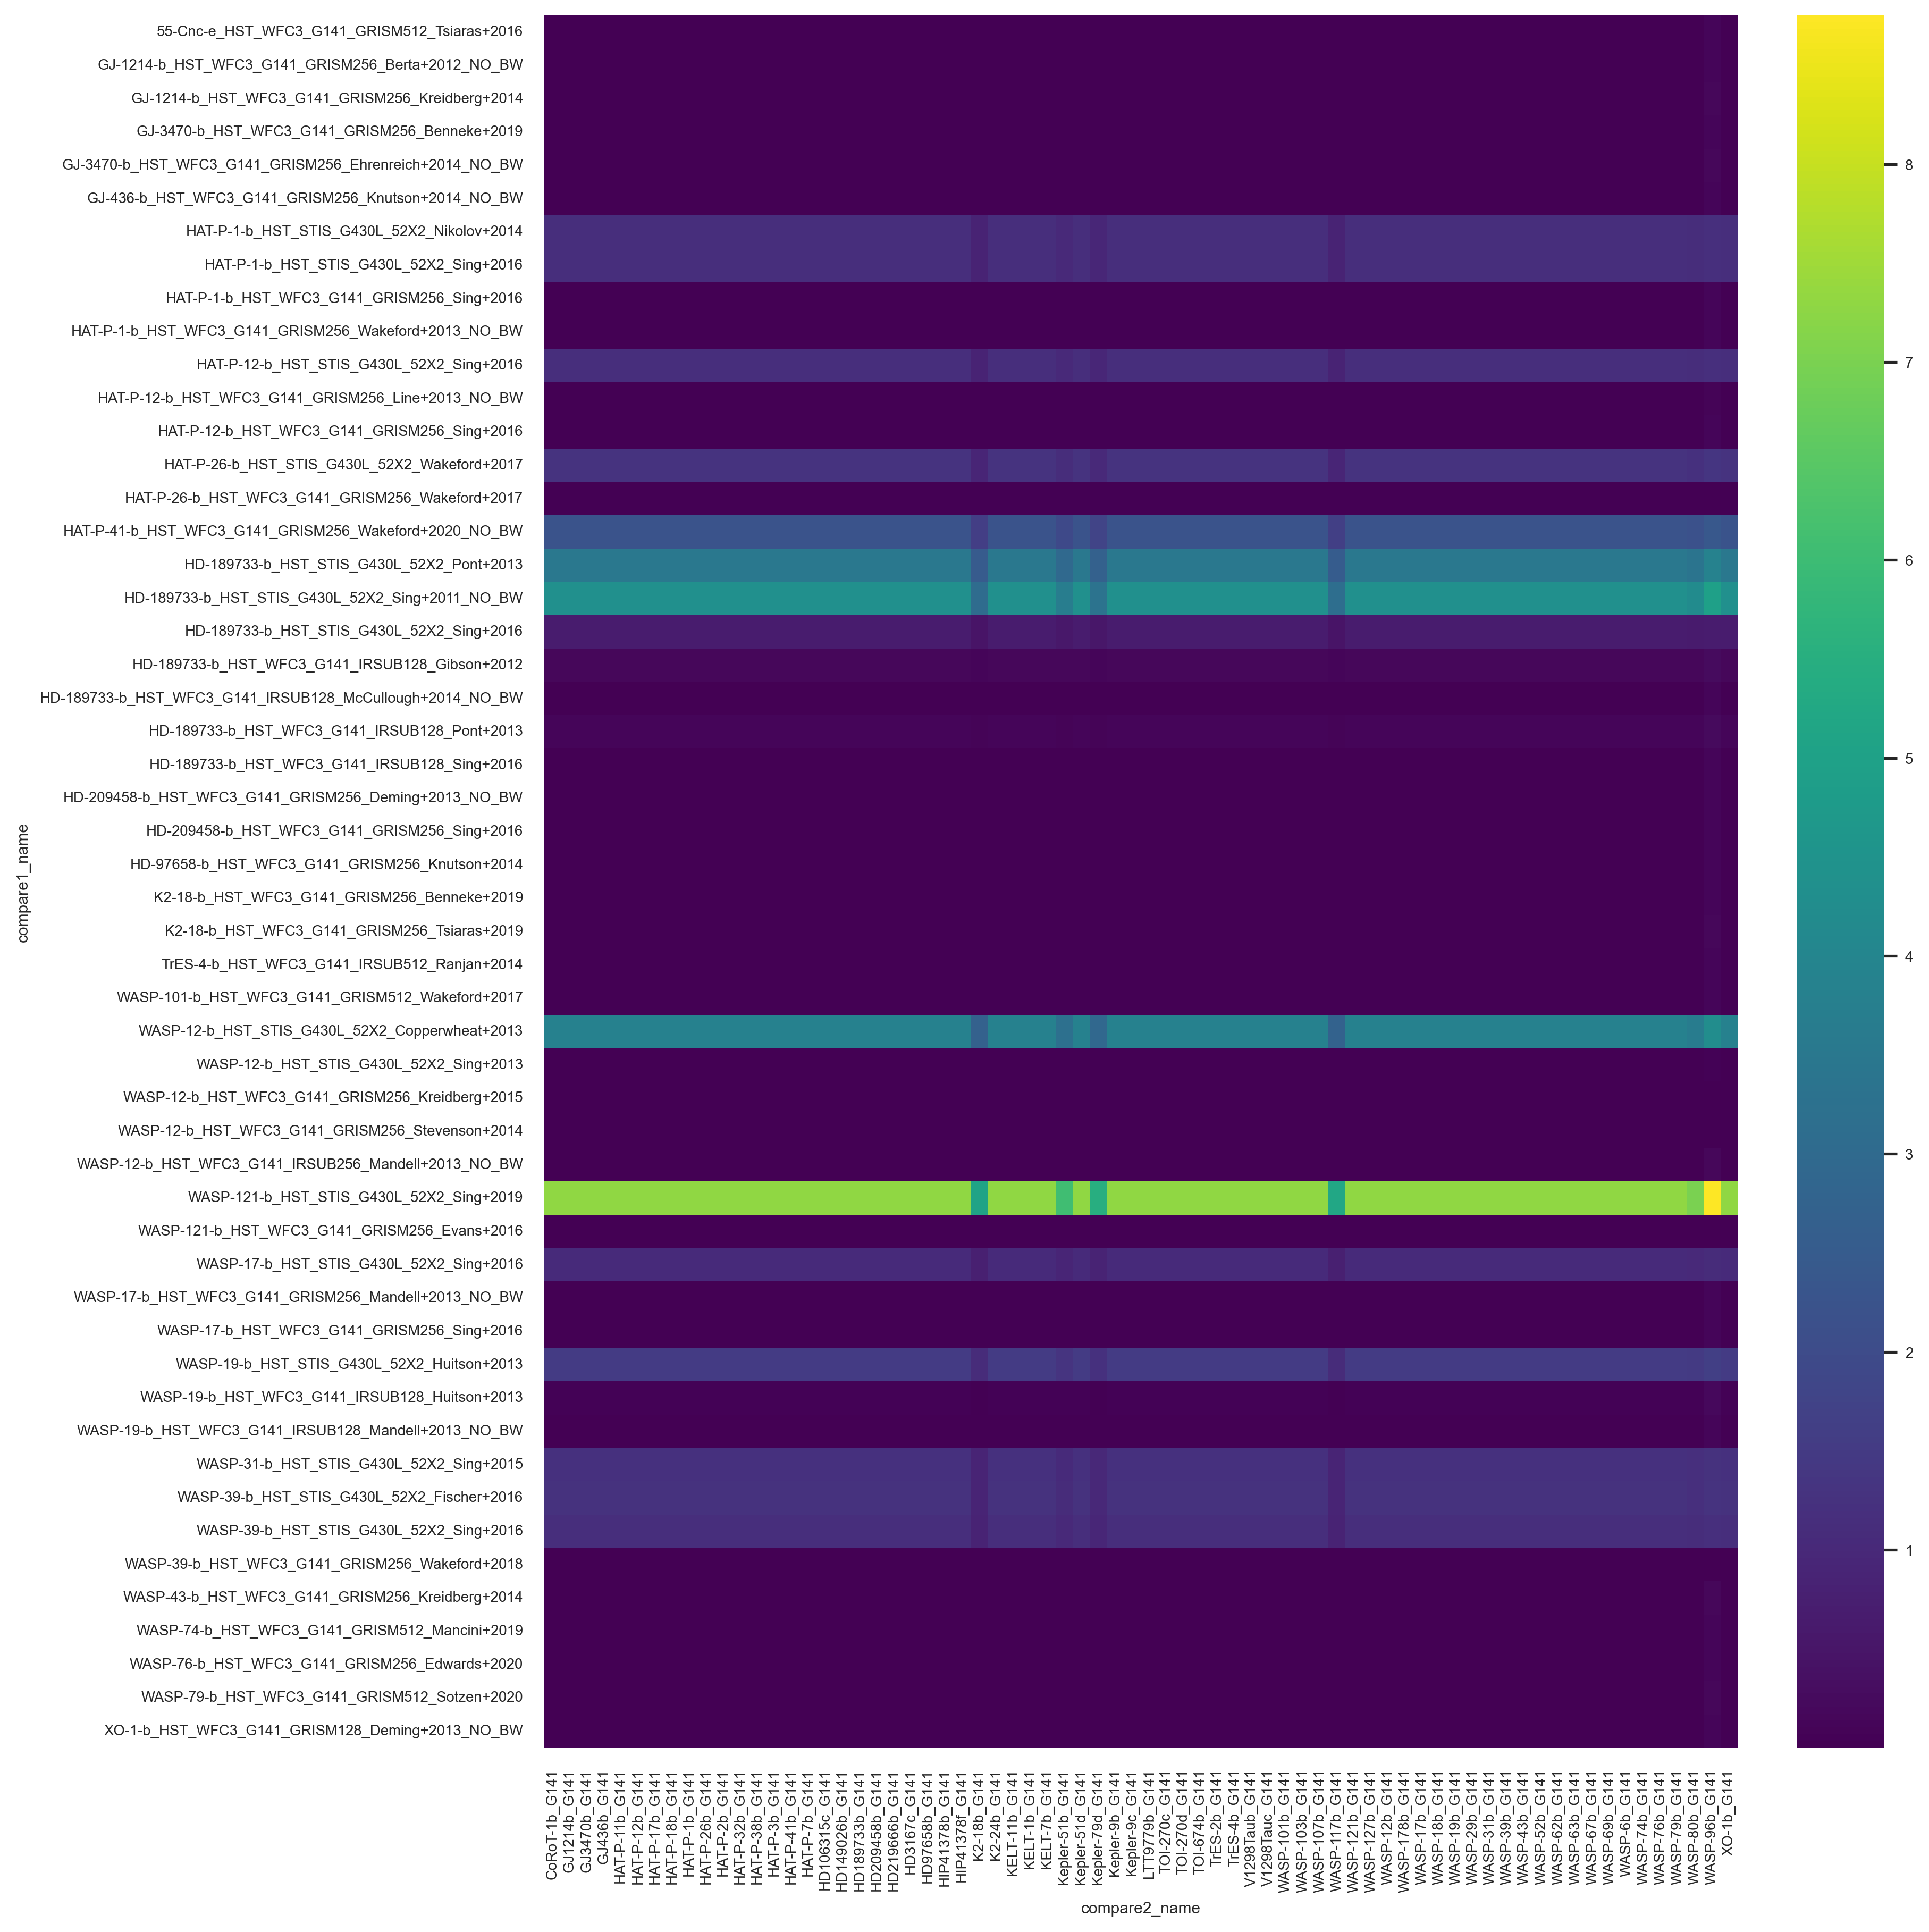

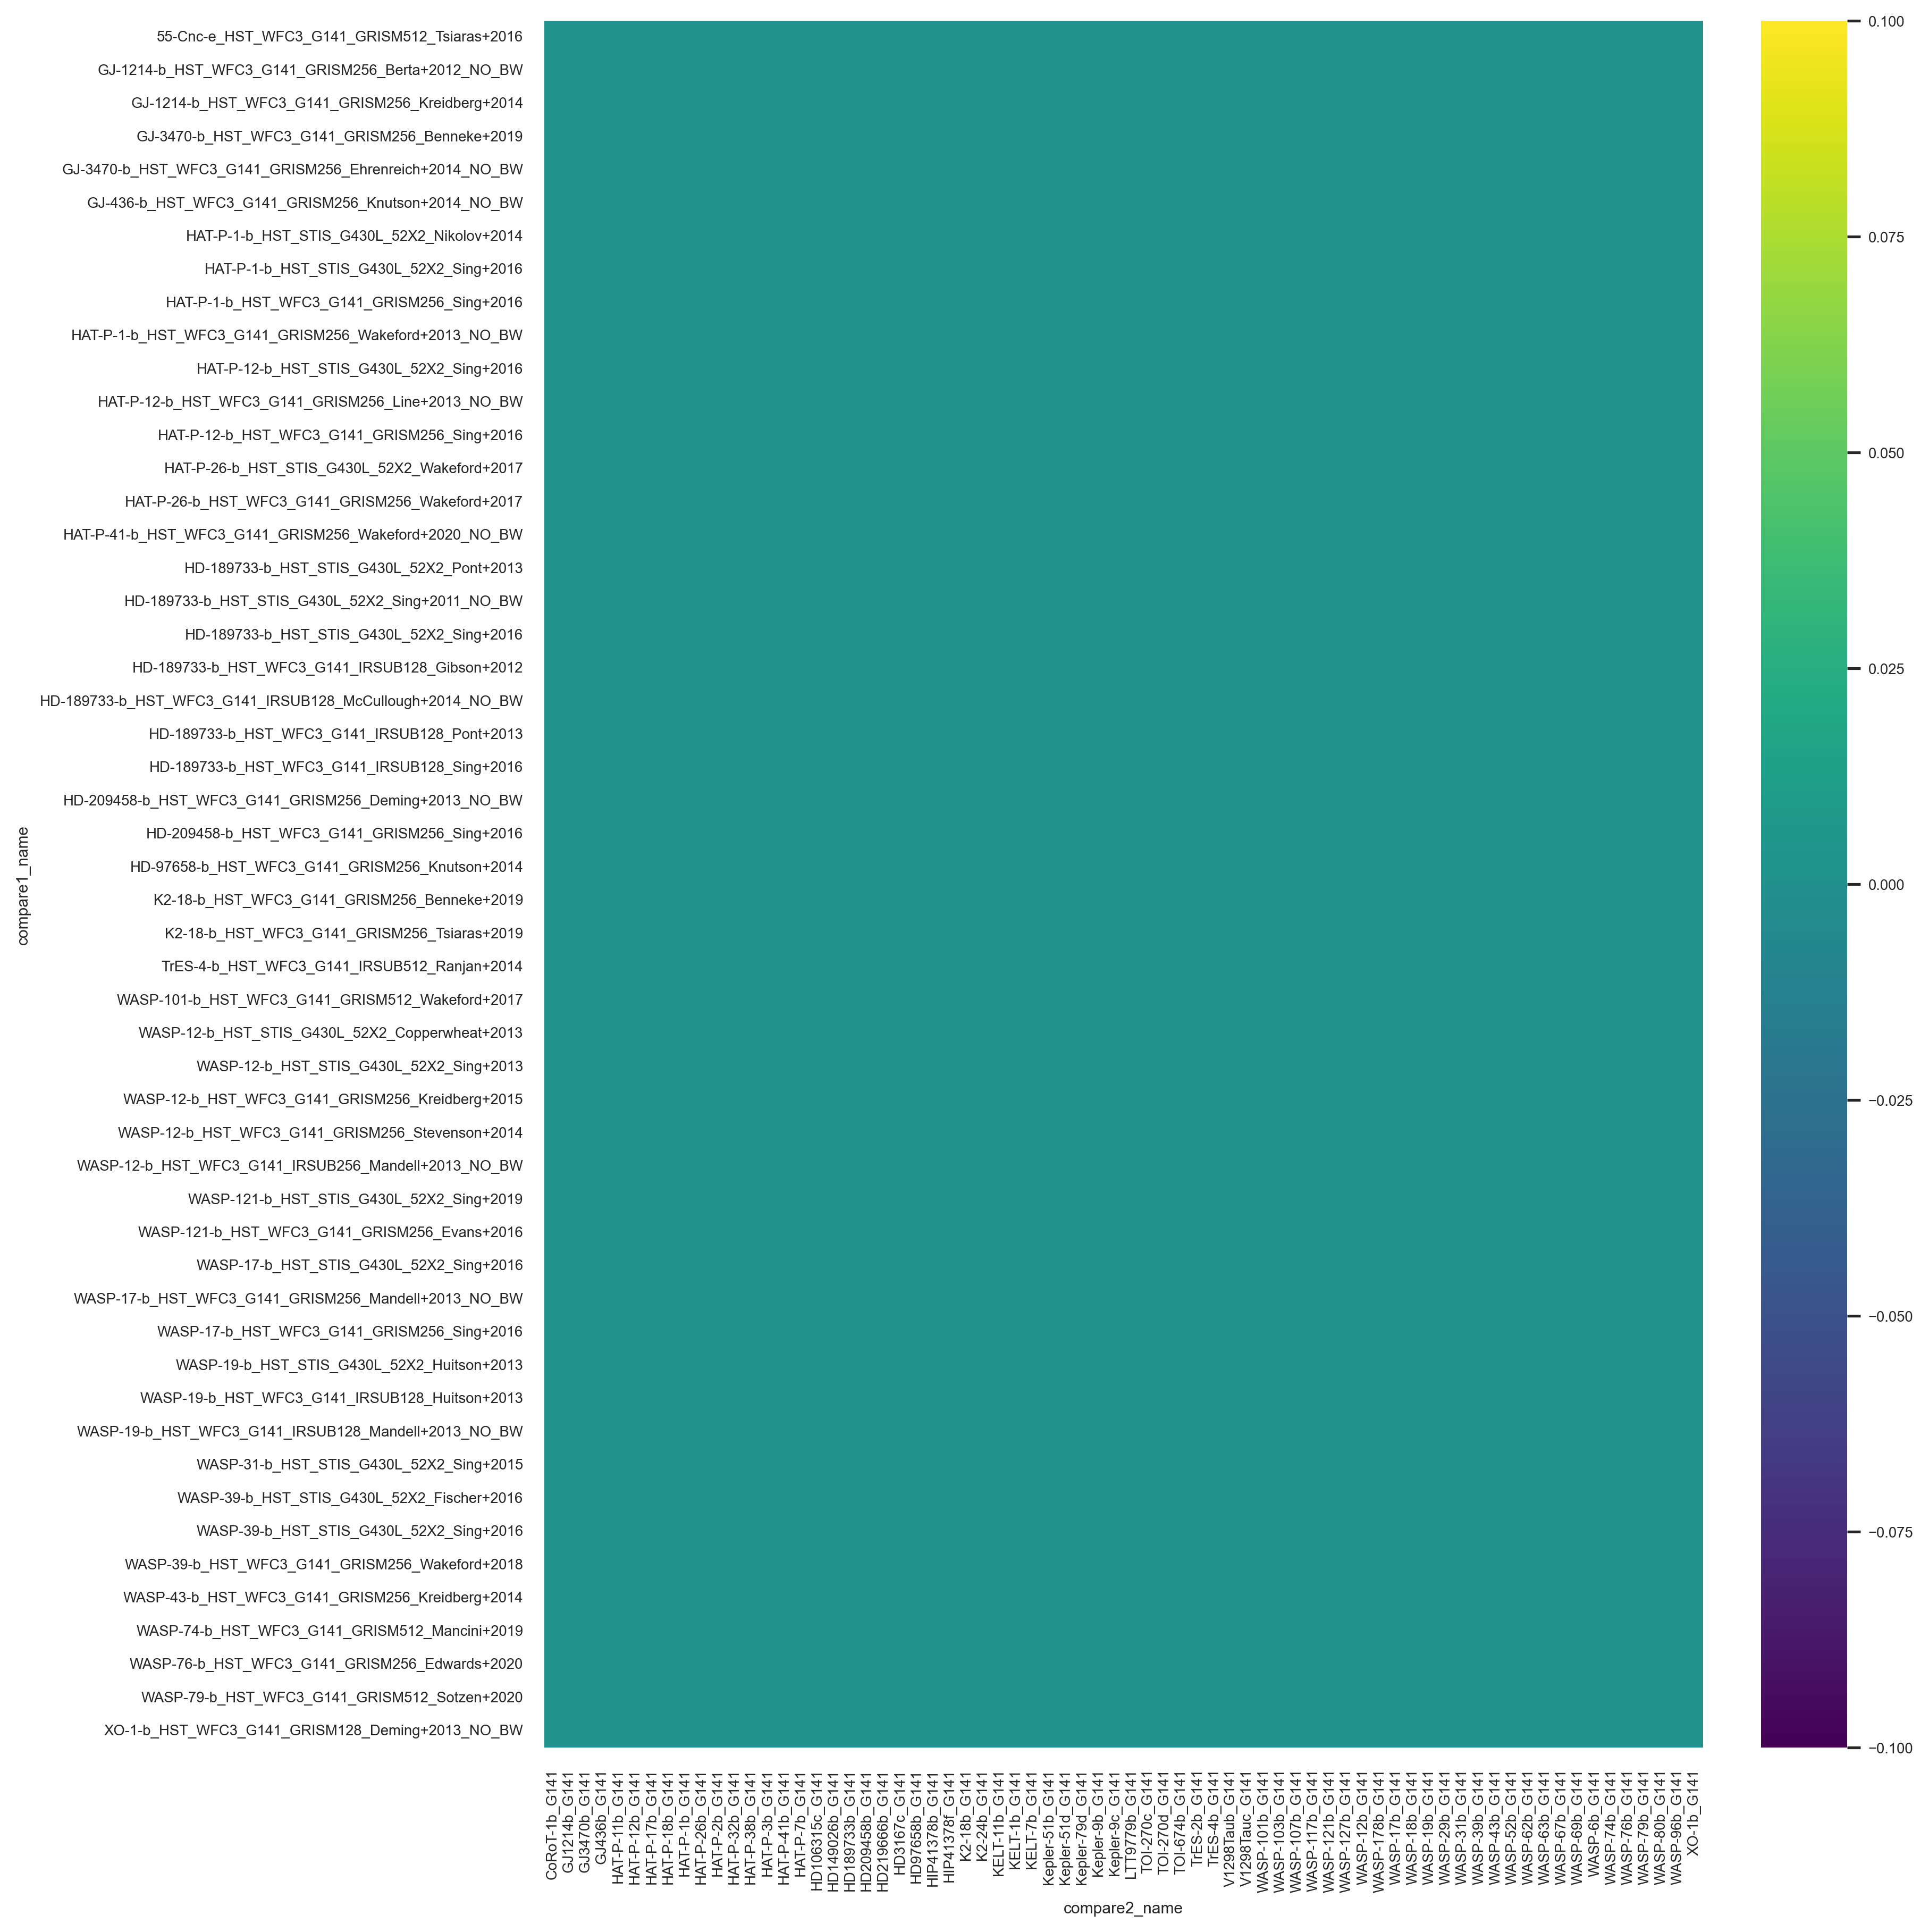

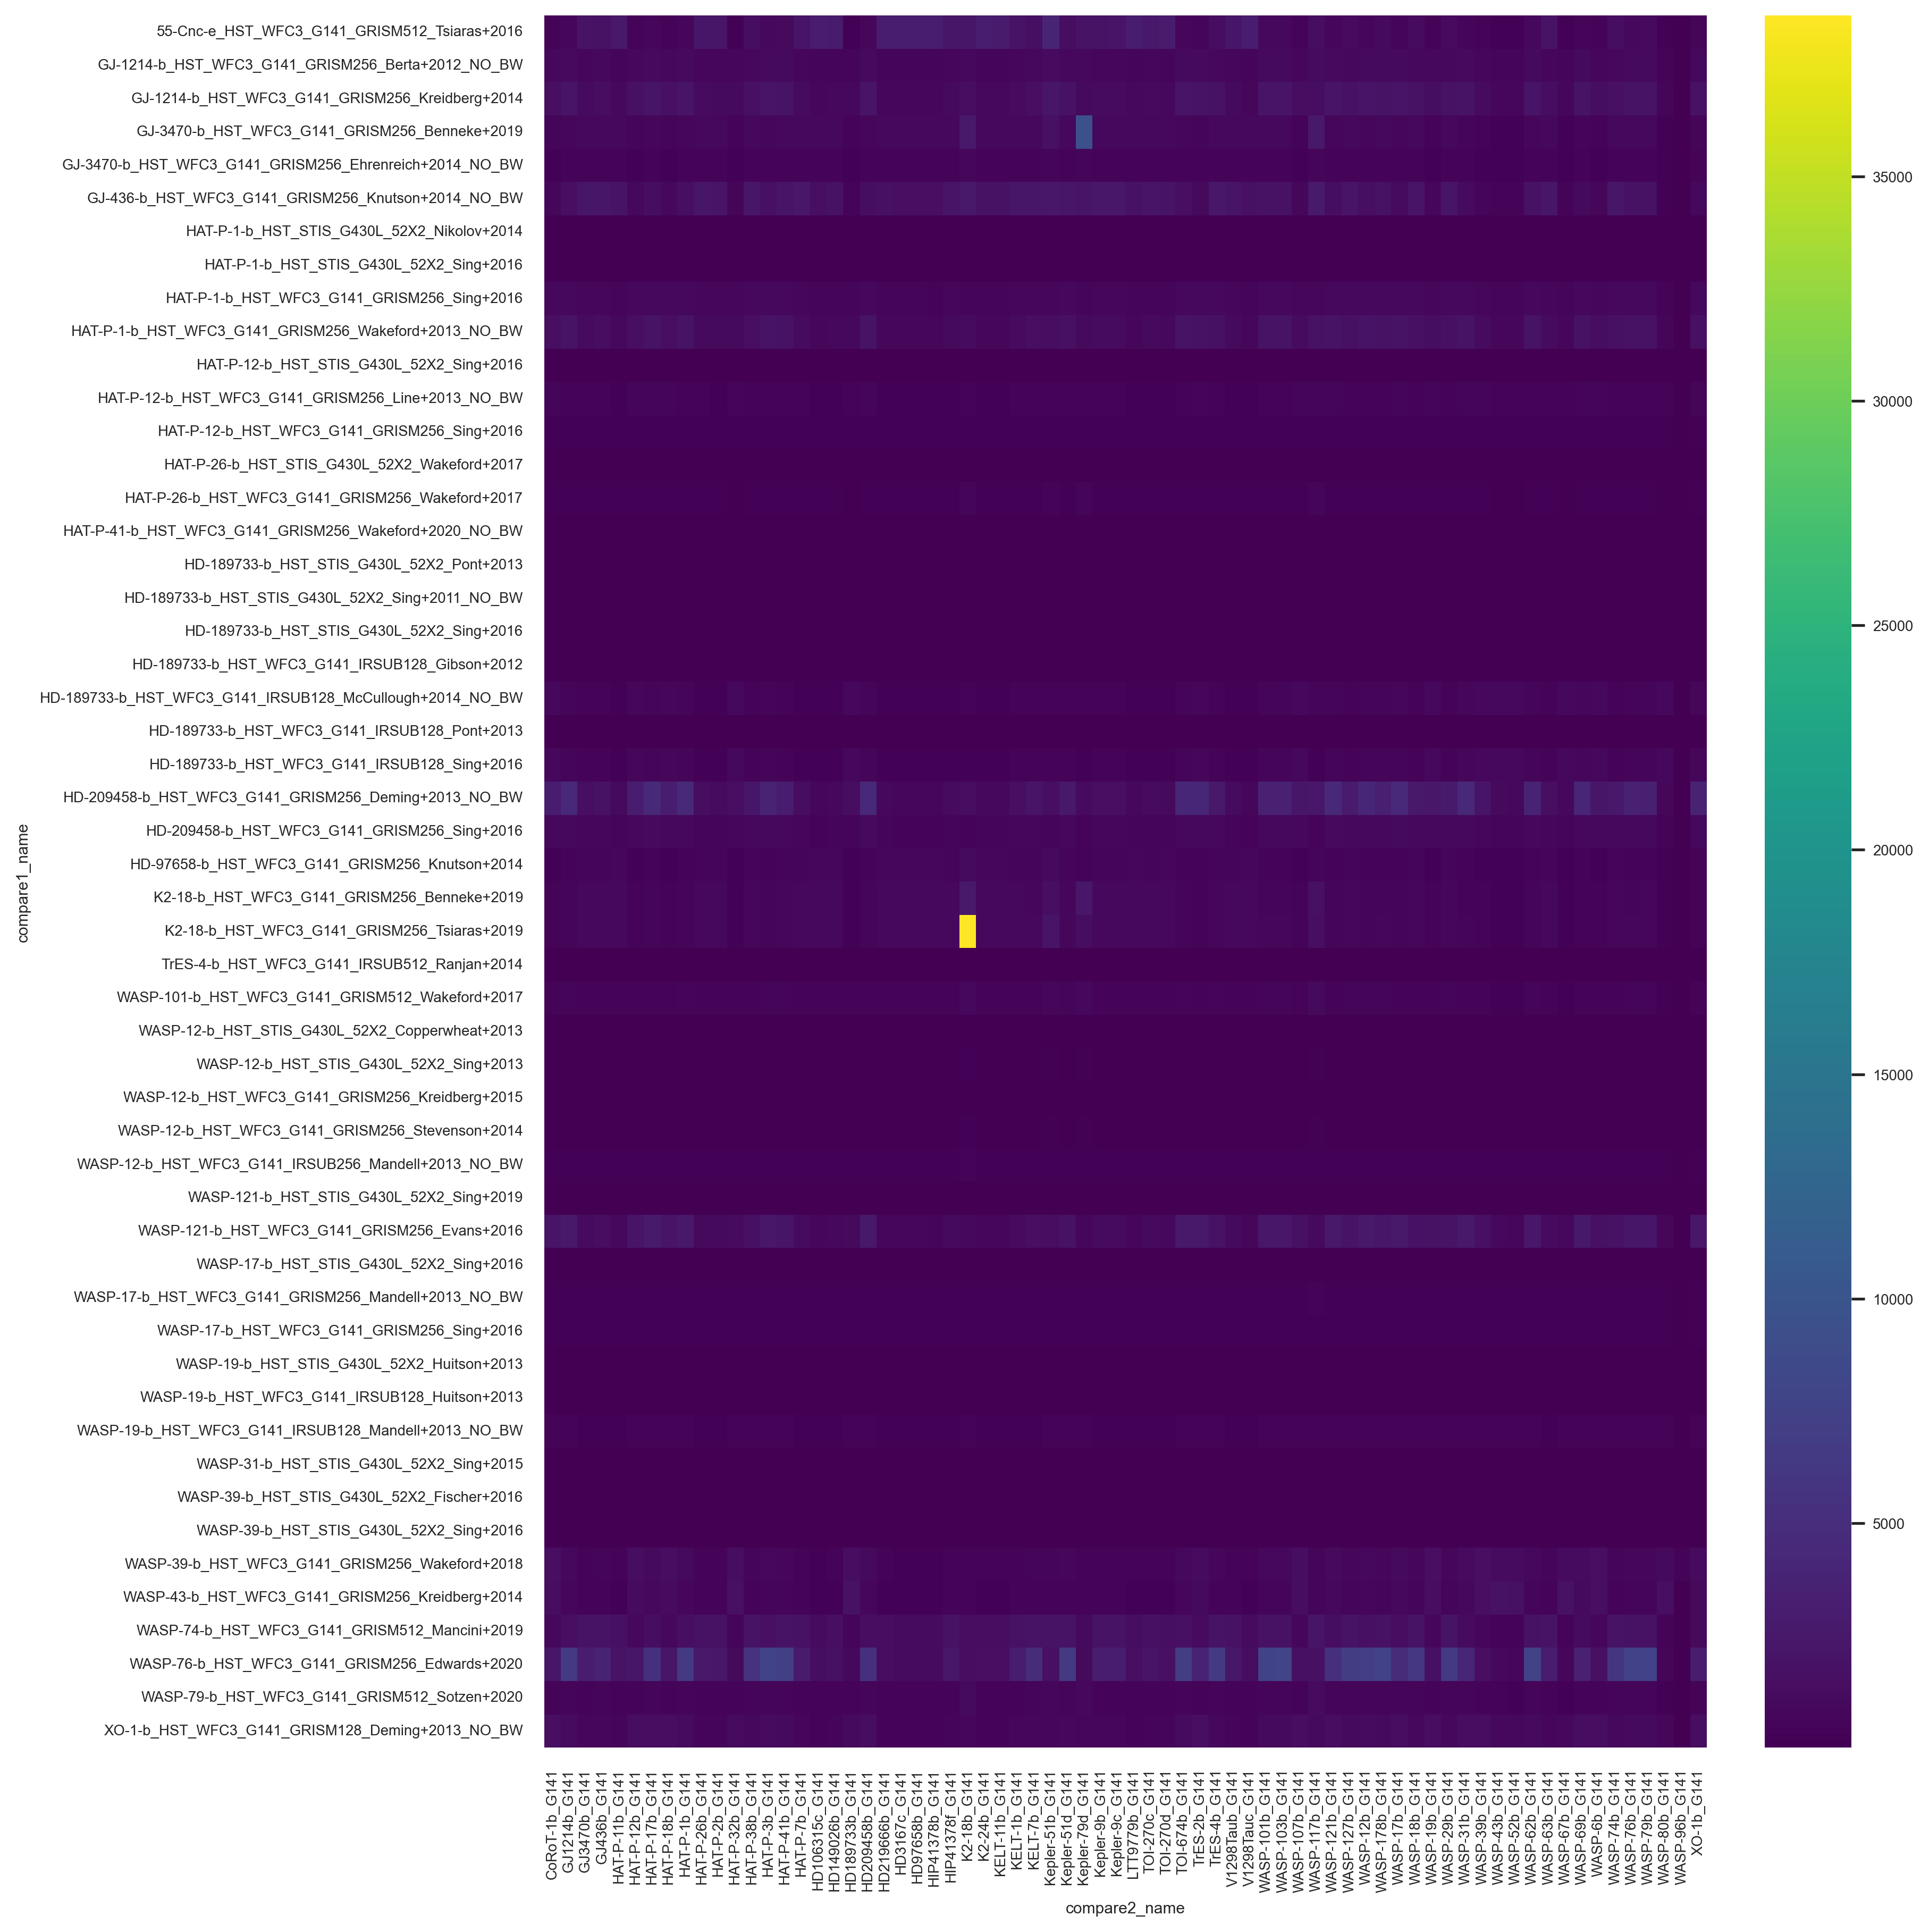

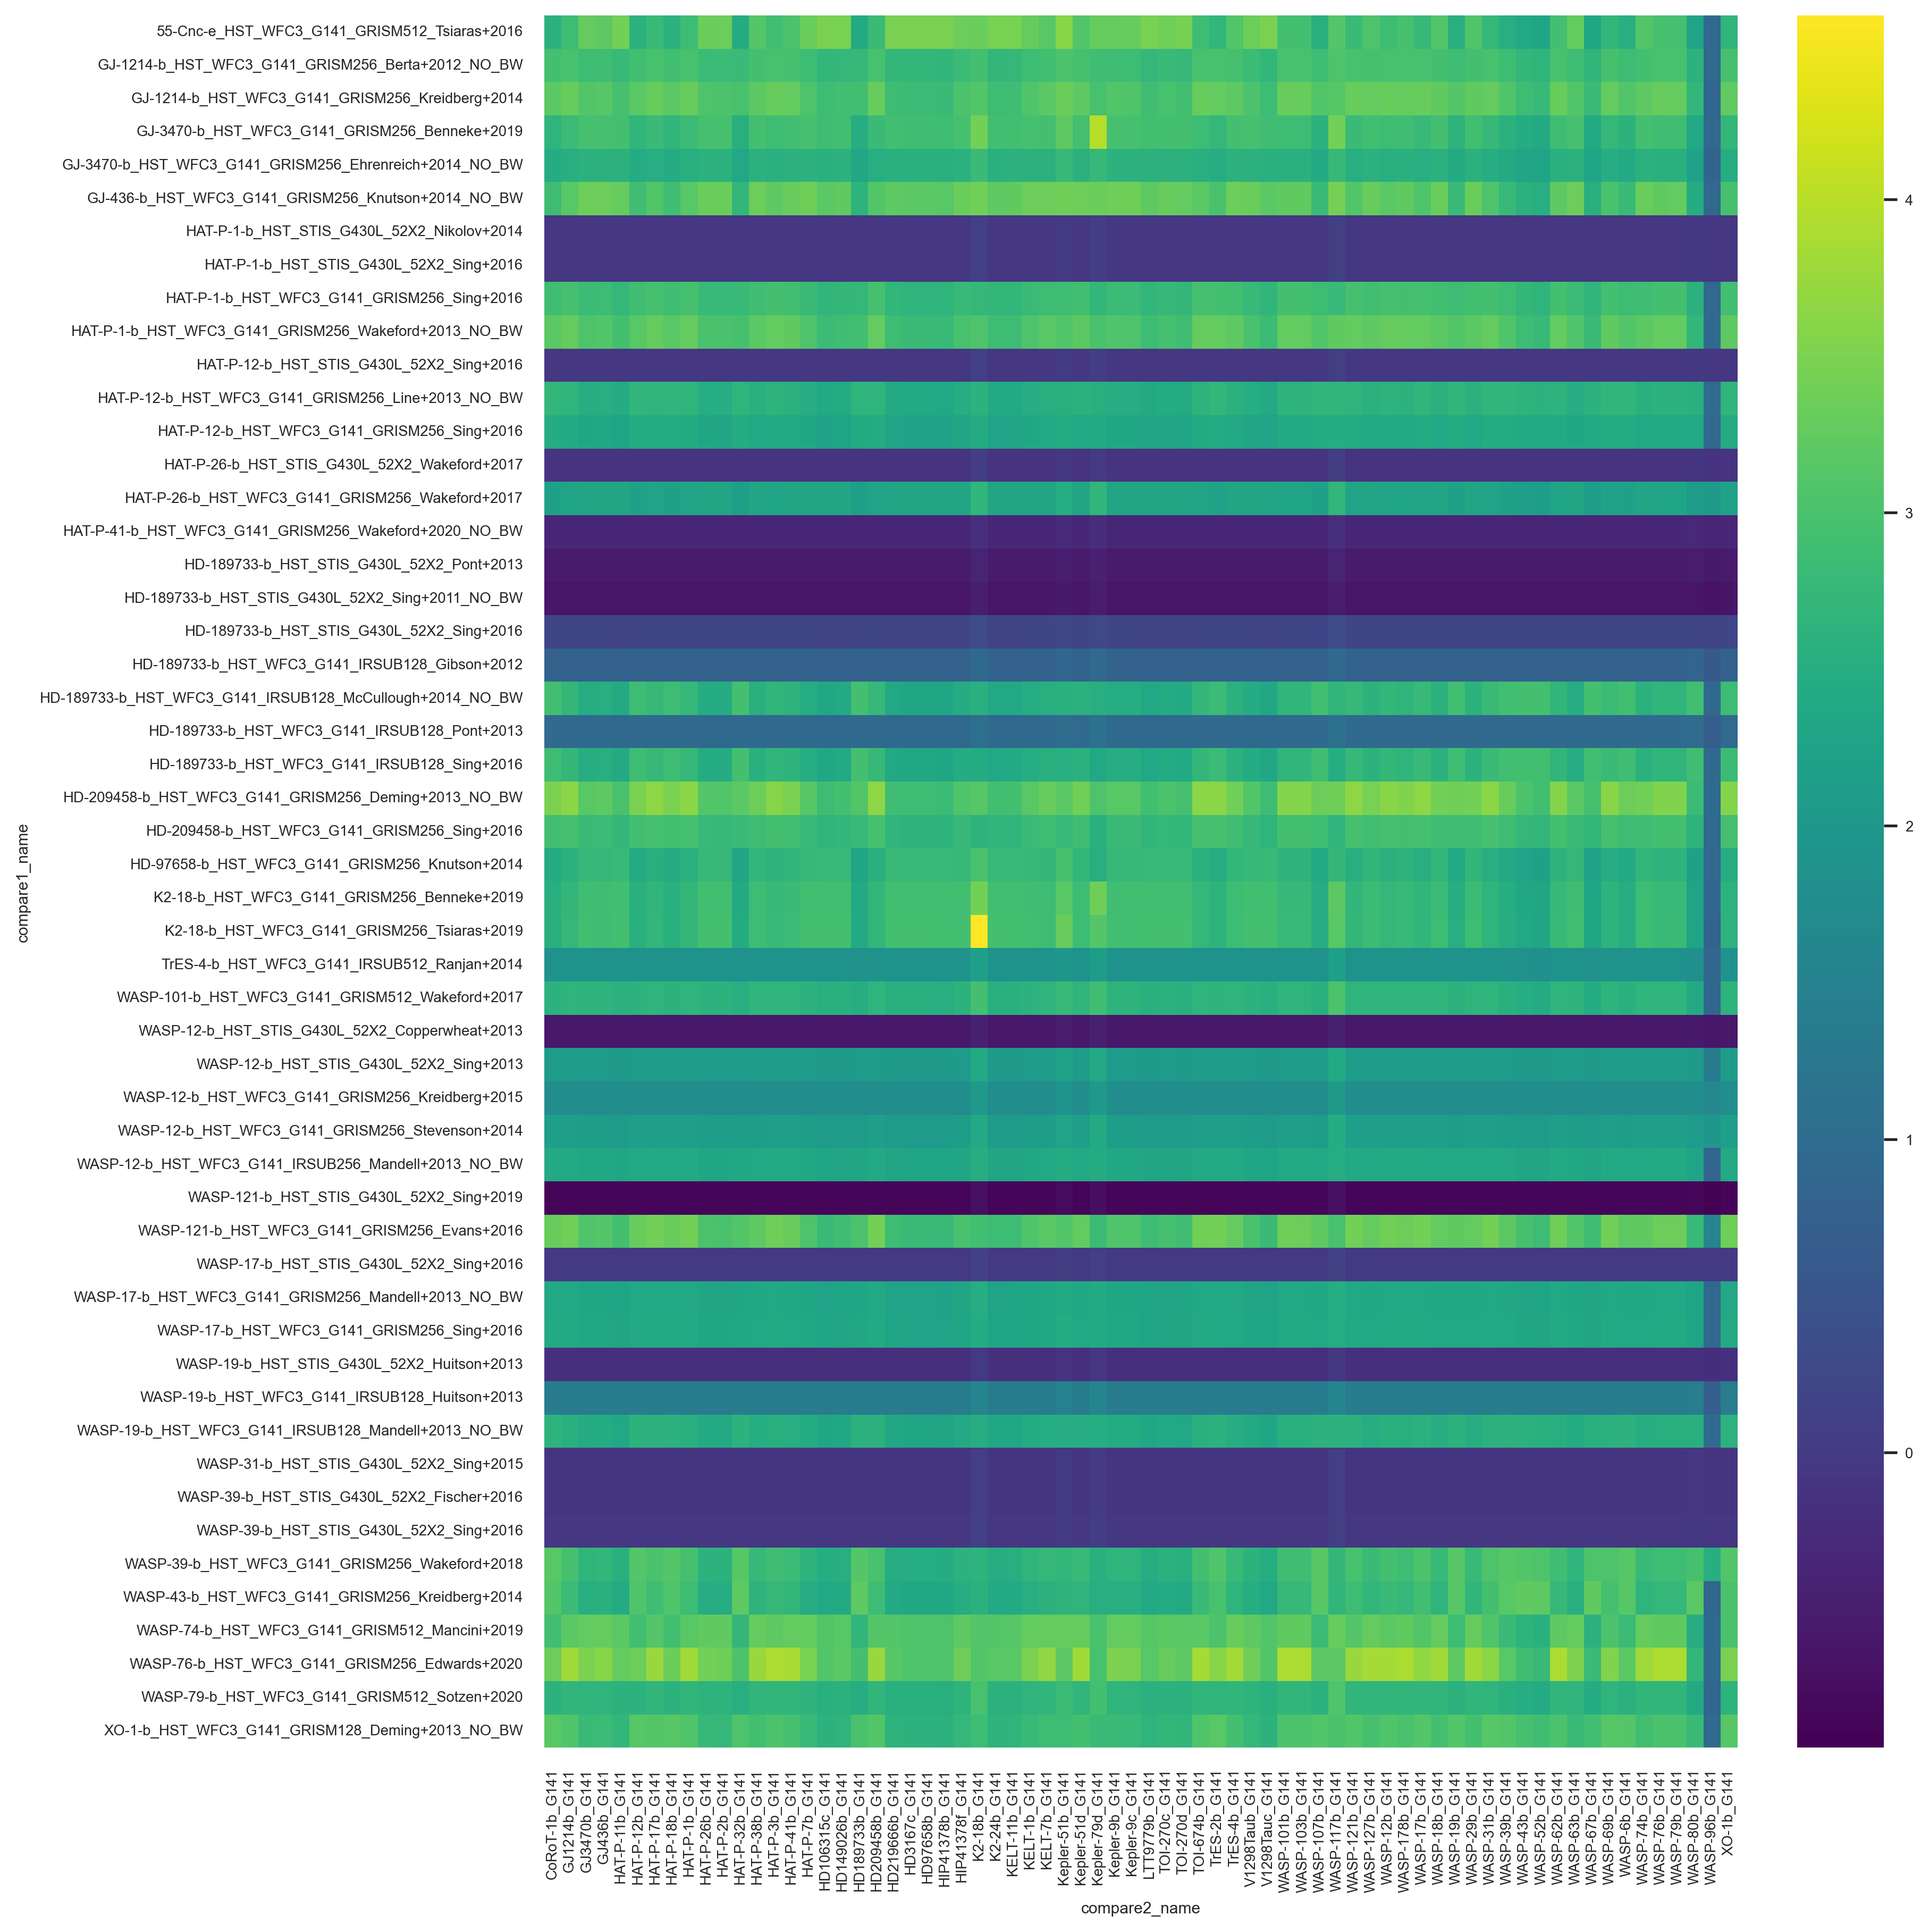

In [86]:
def plot_correlation_matrix(df, which='normalized_diff', filename="correlation_input_txts.png"):
    """
    Plots a correlation matrix for a pandas DataFrame with categorical value pairs and correlation values.

    Parameters:
    df (pandas.DataFrame): DataFrame containing categorical value pairs and correlation values.
        - Must have columns "compare1_name", "compare2_name", and "normalized_diff".
        - The values in "compare1_name" and "compare2_name" will be used for the x and y axis labels.
        - The values in "normalized_diff" will be used as the correlation values.

    Returns:
    None
    """
    # Pivot the DataFrame so that each pair of values is a separate row
    df_pivot = pd.pivot_table(df, values=which, index='compare1_name', columns='compare2_name')

    sns.set(style="white")
    plt.figure(figsize=(12, 12), constrained_layout=True)

    # Generate the heatmap using seaborn
    sns.set(font_scale=0.6)
    sns.heatmap(df_pivot, cmap='viridis', annot=False)

    # Show the plot
    plt.savefig(WDIR / "data/figures" / filename, dpi=300)

plot_correlation_matrix(df_BE_LW_comparison);
plot_correlation_matrix(df_BE_LW_comparison, which="row_match_ratio", filename="row_match_input_txts.png");
plot_correlation_matrix(df_BE_LW_comparison, which="normalized_close", filename="inv_correlation_input_txts.png");
plot_correlation_matrix(df_BE_LW_comparison, which="normalized_close_log", filename="inv_correlation_log_input_txts.png");